In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.callbacks import Callback

In [2]:
# 定义类别
labels = ['零','一','二','三','四','五','六','七','八','九','十','百','千','万','亿']
label_dict = {idx: label for idx, label in enumerate(labels)}
print(label_dict)
# 数据集路径
data_path = 'data/RawDataset'

# 数据加载和预处理函数
def load_data(data_path):
    images = []
    targets = []
    
    # 遍历数据集文件夹中的所有图片
    for filename in os.listdir(data_path):
        if filename.endswith('.jpg'):
            img_path = os.path.join(data_path, filename)
            
            # 提取标签信息（文件名的最后一个数字作为标签）
            base_name = filename.rsplit('.', 1)[0]
            # 去掉大括号
            base_name = base_name.strip('{}')
            # 提取最后一个数字
            label = base_name.split(',')[-1]
            #print(label,"!!!!")
            
            # 读取并预处理图像
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # 读取灰度图像
            img = cv2.resize(img, (64, 64))  # 调整为64x64
            img = img.astype('float32') / 255.0  # 归一化
            
            # 存储图像和标签
            images.append(img)
            targets.append(int(label)-1)  # 获取对应的标签
        
    return np.array(images), np.array(targets)

# 加载数据
images, targets = load_data(data_path)

# 添加一个通道维度，符合CNN的输入要求
images = np.expand_dims(images, axis=-1)

# 标签独热编码
targets = to_categorical(targets, num_classes=15)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.2, random_state=42)

{0: '零', 1: '一', 2: '二', 3: '三', 4: '四', 5: '五', 6: '六', 7: '七', 8: '八', 9: '九', 10: '十', 11: '百', 12: '千', 13: '万', 14: '亿'}


In [3]:
# 设置超参数
epochs = 20
batch_size = 64

In [4]:
#绘图准备
# 1. 绘制混淆矩阵
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# 2. 绘制训练过程中的准确率和AUC
class TrainingHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        auc = logs.get('auc') if 'auc' in logs else None
        
        # 保存数据
        if not hasattr(self, 'accs'):
            self.accs = {'train': [], 'val': []}
            self.auc_scores = {'train': [], 'val': []}
        
        self.accs['train'].append(acc)
        self.accs['val'].append(val_acc)
        if auc is not None:
            self.auc_scores['train'].append(auc)
            self.auc_scores['val'].append(logs.get('val_auc'))
        
        # 打印一下指标
        print(f"Epoch {epoch+1}: accuracy={acc}, val_accuracy={val_acc}, auc={auc}")

# 3. 准备训练过程中的可视化数据
# 在训练时，你可以记录这些指标，训练完成后可以绘制出这些曲线。
history = TrainingHistory()

In [5]:
# 构建卷积神经网络模型
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(labels), activation='softmax')
])

# 编译模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

# 保存模型路径，包含epoch数
model_save_path = f'cnn_parameter/handwritten_digit_recognition_model_cnn_epoch_{epochs}.h5'

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[history])
# # 创建模型保存回调
# checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# # 训练模型
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[checkpoint])

# 保存最终的模型
model.save(model_save_path)
print(f"模型已保存到 {model_save_path}")

Epoch 1/20
188/188 [==============================] - 7s 36ms/step - loss: 1.1565 - accuracy: 0.6447 - auc: 0.9462 - val_loss: 0.5160 - val_accuracy: 0.8277 - val_auc: 0.9891
Epoch 2/20
188/188 [==============================] - 7s 35ms/step - loss: 0.3265 - accuracy: 0.8956 - auc: 0.9953 - val_loss: 0.2741 - val_accuracy: 0.9140 - val_auc: 0.9961
Epoch 3/20
188/188 [==============================] - 7s 35ms/step - loss: 0.1884 - accuracy: 0.9380 - auc: 0.9983 - val_loss: 0.2125 - val_accuracy: 0.9287 - val_auc: 0.9973
Epoch 4/20
188/188 [==============================] - 7s 35ms/step - loss: 0.1107 - accuracy: 0.9645 - auc: 0.9993 - val_loss: 0.1759 - val_accuracy: 0.9403 - val_auc: 0.9980
Epoch 5/20
188/188 [==============================] - 7s 35ms/step - loss: 0.0777 - accuracy: 0.9768 - auc: 0.9997 - val_loss: 0.1801 - val_accuracy: 0.9427 - val_auc: 0.9970
Epoch 6/20
188/188 [==============================] - 7s 35ms/step - loss: 0.0622 - accuracy: 0.9808 - auc: 0.9997 - val_loss

94/94 [==============================] - 1s 8ms/step
[ 5 10  2 ...  8 11  3]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


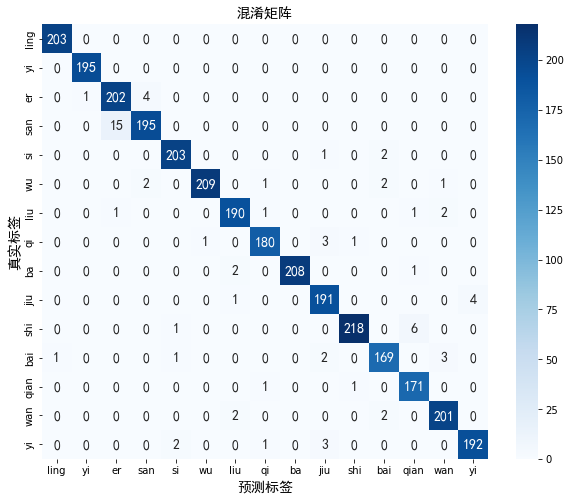

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


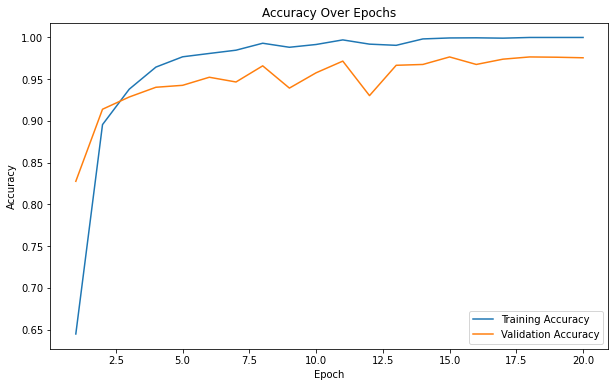

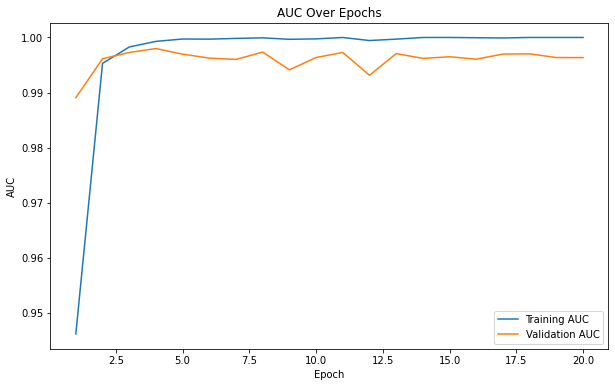

In [6]:
import warnings
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
from matplotlib.font_manager import FontProperties

# 忽略警告信息
warnings.filterwarnings("ignore")

# 设置Matplotlib字体以支持中文
font_path = 'font/simhei.ttf'  # 替换为你的字体文件路径
font = FontProperties(fname=font_path, size=14)

# 设置Matplotlib字体
plt.rcParams['font.sans-serif'] = [font.get_name()]
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# 获取预测结果
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # 得到预测类别
y_true_classes = np.argmax(y_test, axis=1)  # 得到真实标签

# 绘制混淆矩阵
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    conf_df = pd.DataFrame(cm, index=labels, columns=labels)  # 将data和all_label_names制成DataFrame
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_df, annot=True, fmt="d", cmap="Blues", annot_kws={"fontproperties": font})
    plt.title('混淆矩阵', fontproperties=font)
    plt.ylabel('真实标签', fontproperties=font)
    plt.xlabel('预测标签', fontproperties=font)
    plt.show()

labels = ['零', '一', '二', '三', '四', '五', '六', '七', '八', '九', '十', '百', '千', '万', '亿']
labels = ['ling', 'yi', 'er', 'san', 'si', 'wu', 'liu', 'qi', 'ba', 'jiu', 'shi', 'bai', 'qian', 'wan', 'yi']
# 获取预测结果
y_pred_classes = np.argmax(y_pred, axis=1)  # 得到预测类别
y_true_classes = np.argmax(y_test, axis=1)  # 得到真实标签
print(y_pred_classes)

# 绘制混淆矩阵
plot_confusion_matrix(y_true_classes, y_pred_classes, labels)


# 绘制准确率曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), history.accs['train'], label='Training Accuracy')
plt.plot(range(1, epochs + 1), history.accs['val'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 绘制AUC曲线（如果有计算AUC的话）
if history.auc_scores['train']:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), history.auc_scores['train'], label='Training AUC')
    plt.plot(range(1, epochs + 1), history.auc_scores['val'], label='Validation AUC')
    plt.title('AUC Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()